In [1]:
%matplotlib inline


# Datasets & DataLoaders


Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark your model. You can find them
here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)




## Loading a Dataset

Here is an example of how to load the [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples.
Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations



In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%
100.0%
100.0%
100.0%


## Preparing your data for training with DataLoaders
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.



In [3]:
from torch.utils.data import DataLoader
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over
the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


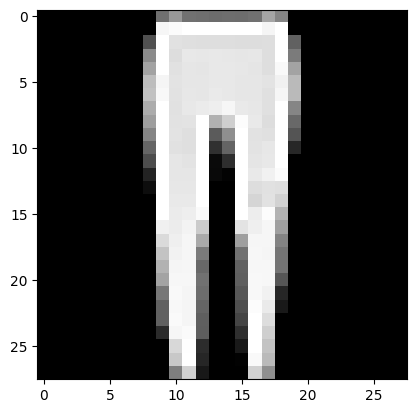

Label: 1


In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
Take a look at this implementation; the FashionMNIST images are stored
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In the next sections, we'll break down what's happening in each of these functions.



In [5]:
import os
import pandas as pd
from torchvision.io import read_image, ImageReadMode

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __init__

The __init__ function is run once when instantiating the Dataset object. We initialize
the directory containing the images, the annotations file, and both transforms (covered
in more detail in the next section).

The labels.csv file looks like: ::

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [7]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

The __len__ function returns the number of samples in our dataset.

Example:



In [8]:
def __len__(self):
    return len(self.img_labels)

### __getitem__

The __getitem__ function loads and returns a sample from the dataset at the given index ``idx``.
Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the
corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the
tensor image and corresponding label in a tuple.



In [9]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

<div style="border: solid 3px #fff;">
    <h1 style="text-align: center; color:#fff; font-family:Georgia; font-size:26px;">Exercise</h1>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 1. Download Children vs Adults Classification dataset from Kaggle (https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images)  </h1>
    <p style='text-align: left;'> </p>
     <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 2. Write a code for the Class of custom dataset with this dataset. This class should get a directory of files as the input of its init function. The image should be converted to a grayscale format using torchvision.io.read_image(mode=ImageReadMode.GRAY)</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; Add an option to normalize the pixel's value to the range of 0 and 1.</h1>
    <p style='text-align: left;'> </p>
</div>

In [32]:
from torchvision.transforms import transforms
import os

class CustomDataset(Dataset):
    def __init__(self, img_dir, normalize=True):
        self.img_dir = img_dir
        self.file_list = ["adults/" + x for x in os.listdir(f"{img_dir}/adults")]+["children/" + x for x in os.listdir(f"{img_dir}/children")]

        self.label_list = [0 for _ in os.listdir(f"{img_dir}/adults")]+[1 for _ in os.listdir(f"{img_dir}/children")]

        self.normalize = normalize

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        # On retourne le contenu du fichier
        image = read_image(self.img_dir + self.file_list[idx], mode=ImageReadMode.GRAY)[0]

        if self.normalize:
            # doc ici: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
            image = image/256

        return image, self.label_list[idx]

<div style="border: solid 3px #fff;">
    <h1 style="text-align: center; color:#fff; font-family:Georgia; font-size:26px;">Exercise</h1>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 1. Creat a DataLoader for train data and a DataLoader for test set with batch_size=10. (use torch.utils.data.DataLoader)</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 2. How many samples are in the training and test? (use __len__())</h1>
    <p style='text-align: left;'> </p>
</div>

In [77]:
from torch.utils.data import DataLoader

training_data=CustomDataset("img/train/")
test_data=CustomDataset("img/test/")

# your code is missing here
batch_size = 10

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print("Train size:", training_data.__len__())
print("Test size:", test_data.__len__())

Train size: 680
Test size: 120


<div style="border: solid 3px #fff;">
    <h1 style="text-align: center; color:#fff; font-family:Georgia; font-size:26px;">Exercise</h1>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 1. Instead of using next(iter(x_dataloader)) command to itteratively read and load samples, write a 'for' loop as follow : 'for x,y in x_dataloader:'.</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 2. How many samples are yielded (returned) in each loop? How this number can be changed?</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 3. By runing several times the loop, check if the order of returened samples are same? how it can be changed?</h1>
    <p style='text-align: left;'> </p>
</div>

In [79]:
for x,y in train_dataloader:
    print("Samples per loop:", len(x))
    print(y)
    break
# On a 10 valeurs par tour de boucle, on peut le changer en augmentant la taille du batch
# On a un ordre différent à chaque exécution. Pour changer ça on met shuffle à False lors de la création du dataloader


Samples per loop: 10
tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0])


<div style="border: solid 3px #fff;">
    <h1 style="text-align: center; color:#fff; font-family:Georgia; font-size:26px;">Exercise</h1>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 1. Change the return of your CustomDataset to have the directory address of samples as well in the output. </h1>
    <h1 style="text-align: left; color:#fff; font-family:Courier; font-size:16px;"> &emsp; 2. Then confirm that your CustomDataset is working correctly.</h1>
    <p style='text-align: left;'> </p>
</div>

In [88]:
# your code is missing here
class CustomDataset(Dataset):
    def __init__(self, img_dir, normalize=True):
        self.img_dir = img_dir
        self.file_list = ["adults/" + x for x in os.listdir(f"{img_dir}/adults")]+["children/" + x for x in os.listdir(f"{img_dir}/children")]

        self.label_list = [0 for _ in os.listdir(f"{img_dir}/adults")]+[1 for _ in os.listdir(f"{img_dir}/children")]

        self.normalize = normalize

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        # On retourne le contenu du fichier
        img_path = self.img_dir + self.file_list[idx]
        image = read_image(img_path, mode=ImageReadMode.GRAY)[0]

        if self.normalize:
            # doc ici: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
            image = image/256

        return image, img_path, self.label_list[idx]


In [90]:
training_data=CustomDataset("img/train/")
test_data=CustomDataset("img/test/")

# your code is missing here
batch_size = 10

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print("Train size:", training_data.__len__())
print("Test size:", test_data.__len__())

for x,y,z in train_dataloader:
    print("File addresses/Labels:", y, z)
    break

Train size: 680
Test size: 120
File addresses/Labels: ('img/train/adults/314.jpg', 'img/train/adults/387.jpg', 'img/train/adults/304.jpg', 'img/train/children/199.jpg', 'img/train/adults/351.jpg', 'img/train/children/195.jpg', 'img/train/children/306.jpg', 'img/train/children/271.jpg', 'img/train/adults/386.jpg', 'img/train/children/159.jpg') tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1])
